# Keras Mobilenet Model for STM CUBEMX.AI

In [19]:
# Copyright (C) 2019 University of Bologna
#
# Author: Alessandro Capotondi - University of Bologna
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
#
# Mobilenet v1 160x160 0.25 for STMCubeMx.Ai
#

## Import Modules

In [20]:
import keras.backend as K
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.layers import Activation
from keras.layers import ReLU
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

## Function Utilities

In [21]:
# Relu6 Activation
def relu6(x):
    return K.relu(x, max_value=6)

# ReLU Converter Function
# According to the discussion [1], 'keras.advanced_activations.ReLU' layers are not usable directly in ST cubemx.ai.
# The function remove such layers and it substitutes to supported 'keras.activations.relu'
# [1] https://community.st.com/s/question/0D50X0000AVUpc1SQD/keras-import-not-implemented-unsupported-layer-type-relu
def convert_to_cubemx_ai(model):

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if isinstance(layers[i],ReLU):
            #new_layer = \
            #    keras.layers.Activation(lambda x: \
            #            keras.activations.relu(x, \
            #                max_value=layers[i].get_config()["max_value"].item(),\
            #                threshold=layers[i].get_config()["threshold"].item(),\
            #            ))
            #
            new_layer = Activation(relu6, name=layers[i].name)
            #new_layer = Activation('relu')
            #new_layer.name = layers[i].name
            x = new_layer(x)
        else:
            x = layers[i](x)


    return Model(inputs=layers[0].input, outputs=x)

# Test and Compare Function
def test_and_compare_models(test, model, model2):
    from keras.preprocessing import image
    from keras.applications.mobilenet import preprocess_input, decode_predictions
    from IPython.display import Image
    import numpy as np
    
    display(Image(filename=test))
    
    img = image.load_img(test, target_size=(model.input_shape[1],model.input_shape[2]))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    preds2 = model2.predict(x)
    
    print(decode_predictions(preds))
    print(decode_predictions(preds2))


    return preds.sum() == preds2.sum()

## Load pre-trained Model

Load pre-trained Mobilenet model from **Keras.Applications** module

In [22]:
#MobileNet parameters (change it as necessary)
INPUT_SIZE = 128
ALPHA = 0.25

In [23]:
#Import Pre-Trained Mobilenet
mobilenet = MobileNet(input_shape=(INPUT_SIZE,INPUT_SIZE,3), alpha=ALPHA, include_top=True, weights='imagenet', pooling='avg')

2113536/2108140 [==============================] - 1s 0us/step


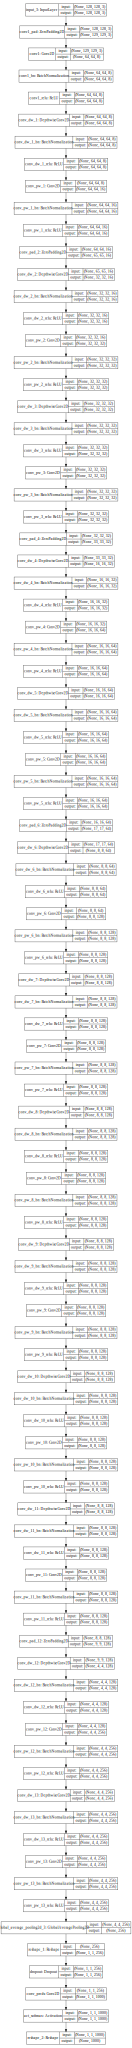

In [24]:
#Visualize the Model
SVG(model_to_dot(mobilenet, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Convert Mobilenet for cubemx.ai

Remove from the loaded model the cubemx.ai unsupported layers [\[1\]](https://community.st.com/s/question/0D50X0000AVUpc1SQD/keras-import-not-implemented-unsupported-layer-type-relu).

In this particular case the layer type to substitue is the **keras.layers.ReLU**. The layers is not directly supported by STMCubeMX.AI, but it can be converted to **keras.layers.Activation**.
This operation is performed by the function **convert_to_cubemx_ai** included in this notebook.
    
---
\[1\] [https://community.st.com/s/question/0D50X0000AVUpc1SQD/keras-import-not-implemented-unsupported-layer-type-relu](https://community.st.com/s/question/0D50X0000AVUpc1SQD/keras-import-not-implemented-unsupported-layer-type-relu)


In [25]:
# Convert the model
cubemxai_mobilenet = convert_to_cubemx_ai(mobilenet)

In [26]:
# Save the new model
cubemxai_mobilenet.save("mobilenet_"+str(INPUT_SIZE)+"_"+str(ALPHA).replace('.', '_')+".h5")

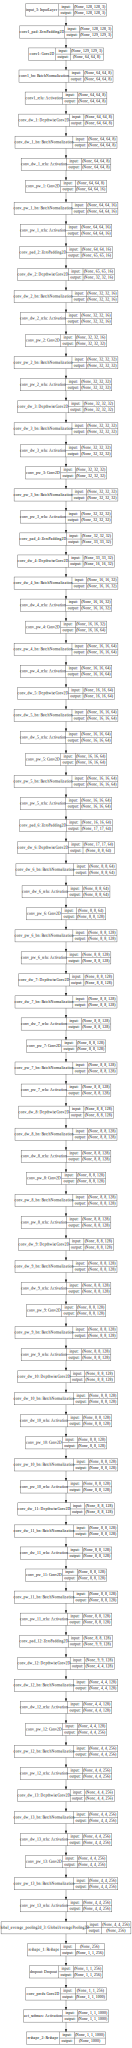

In [27]:
SVG(model_to_dot(cubemxai_mobilenet, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


## Mobilenet without FC layers

In [ ]:
# Convert the model
cubemxai_mobilenet_no_fc = convert_to_cubemx_ai(MobileNet(input_shape=(INPUT_SIZE,INPUT_SIZE,3), alpha=ALPHA, include_top=False, weights='imagenet', pooling='avg'))

2113536/2108140 [==============================] - 1s 0us/step


In [ ]:
# Save the new model
cubemxai_mobilenet_no_fc.save("mobilenet_"+str(INPUT_SIZE)+"_"+str(ALPHA).replace('.', '_')+"_no_fc.h5")

In [ ]:
SVG(model_to_dot(cubemxai_mobilenet_no_fc, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Test the new Mobilenet model agaist the Pre-Trained one

In [ ]:
test = test_and_compare_models("test_image.jpg", mobilenet, cubemxai_mobilenet)

In [ ]:
print("Conversion: " + ("Success!!" if test else "Fail!"))